<a href="https://colab.research.google.com/github/youhangkai/SHARING/blob/main/LSTM_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import auth
auth.authenticate_user()

!pip install earthengine-api
import ee
import numpy as np
import numpy as np
from scipy.interpolate import interp1d

# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=A3Bm8lj8U1veDJqPAUDrSawvWeTo1X_Ro9eTR09WPPY&tc=LJS1cqjOs_-apuIN9ocA0qeqhBqIm1tMA1_mLVEI1GY&cc=GyLR236G2wOy6waCnXDVF1cxUeq0AghdWs9ePg4tQXc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VNzAHCSqH49yVblRC-NvWrkWQDEXZs34HBtVZp1SugGaVXvH9thPa4

Successfully saved authorization token.


In [3]:
import ee

# Define the datasets
gimms_dataset = ee.ImageCollection("NASA/GIMMS/3GV0")
modis_pft_dataset = ee.Image("MODIS/006/MCD12Q1/2001_01_01")
era5_daily_dataset = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")

# Define the time period
start_date = '1980-01-01'
end_date = '1999-12-31'


# Define the region of interest (ROI) as a point or polygon
roi = ee.Geometry.Point(-72.18,42.5311)

# Filter the GIMMS dataset by date and region
gimms_filtered = gimms_dataset.filterDate(start_date, end_date).filterBounds(roi)

# Calculate the land cover class distribution in the region
pft_data = modis_pft_dataset.select("LC_Type1").clip(roi)
pft_histogram = pft_data.reduceRegion(reducer=ee.Reducer.frequencyHistogram(), geometry=roi, scale=500).getInfo()["LC_Type1"]

# Calculate the total number of pixels in the region
total_pixels = sum(pft_histogram.values())

# Calculate the class distribution as a percentage
pft_distribution = {k: v / total_pixels * 100 for k, v in pft_histogram.items()}

# Create a numpy array of the class distribution
pft_np = np.array([pft_distribution.get(str(i), 0) for i in range(1, 18)])

# Filter the ERA5 dataset by date and region
era5_filtered = era5_daily_dataset.filterDate(start_date, end_date).filterBounds(roi)

# Define a function to compute the mean value for the selected meteorology variables in the ERA5 dataset

def calculate_mean(image):
    variables = [
        'dewpoint_temperature_2m',
        'temperature_2m',
        'skin_temperature',
        'surface_solar_radiation_downwards_sum',
        'surface_thermal_radiation_downwards_sum',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m',
        'surface_pressure',
        'total_precipitation_sum'
    ]

    means = image.select(variables).reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=1000)
    mean_image = ee.Image.constant(means.values(variables)).rename(variables)
    return mean_image.copyProperties(image, ["system:time_start"])

# Compute the mean values for the selected meteorological variables
era5_mean = era5_filtered.map(calculate_mean)

def get_data_from_collection(image_collection, bands, roi, scale):
    data_list = image_collection.getRegion(roi, scale).getInfo()
    header = data_list[0]
    data = np.array(data_list[1:])
    
    indices = [header.index(band) for band in bands]
    data_np = data[:, indices]
    time_stamps = data[:, header.index('time')]
    
    return data_np, time_stamps

gimms_bands = ['ndvi']
gimms_np, gimms_time = get_data_from_collection(gimms_filtered, gimms_bands, roi, 8000)

# Create a numpy array of the class distribution
pft_np = np.array([pft_distribution.get(str(i), 0) for i in range(1, 18)])

# Reshape the PFT data to match the GIMMS and ERA5 data
pft_np = np.repeat(pft_np[np.newaxis, :], gimms_np.shape[0], axis=0)

era5_bands = [
    'dewpoint_temperature_2m',
    'temperature_2m',
    'skin_temperature',
    'surface_solar_radiation_downwards_sum',
    'surface_thermal_radiation_downwards_sum',
    'u_component_of_wind_10m',
    'v_component_of_wind_10m',
    'surface_pressure',
    'total_precipitation_sum'
]

def cast_bands_to_float(image):
    bands = image.bandNames()
    return image.toFloat().rename(bands)

era5_mean_float = era5_mean.map(cast_bands_to_float)

era5_mean_np,gimms_time = get_data_from_collection(era5_mean_float, era5_bands, roi, 1000)

import numpy as np
from scipy.interpolate import interp1d

gimms_np = gimms_np.astype(np.float64)
era5_mean_np = era5_mean_np.astype(np.float64)

# Creating Timestamp Arrays
gimms_time = np.arange(0, len(gimms_np))
era5_time = np.linspace(0, len(gimms_np) - 1, len(era5_mean_np))

# Creating interpolation function
interp_func = interp1d(era5_time, era5_mean_np, axis=0, kind='linear', fill_value='extrapolate')

# Use the interpolation function to sample era5_mean_np to the temporal resolution of gimms_np
era5_mean_np_resampled = interp_func(gimms_time)

combined_data_before = np.hstack((gimms_np, pft_np, era5_mean_np_resampled))
print(combined_data_before.shape)

(444, 27)


In [4]:
gimms_np

array([[0.82700002],
       [0.93000001],
       [0.89200002],
       [0.94      ],
       [0.83999997],
       [0.77399999],
       [0.71899998],
       [0.70499998],
       [0.61900002],
       [0.551     ],
       [0.292     ],
       [0.24600001],
       [0.40700001],
       [0.405     ],
       [0.352     ],
       [0.37599999],
       [0.33500001],
       [0.56      ],
       [0.588     ],
       [0.58899999],
       [0.70099998],
       [0.90100002],
       [0.83200002],
       [0.90799999],
       [0.97799999],
       [0.95200002],
       [0.833     ],
       [0.89999998],
       [0.93300003],
       [0.84500003],
       [0.86400002],
       [0.67299998],
       [0.491     ],
       [0.46000001],
       [0.51599997],
       [0.317     ],
       [0.198     ],
       [0.36399999],
       [0.43599999],
       [0.35100001],
       [0.52200001],
       [0.58399999],
       [0.62900001],
       [0.61299998],
       [0.66900003],
       [0.778     ],
       [0.93000001],
       [0.944

In [6]:
gimms_dataset = ee.ImageCollection("NASA/GIMMS/3GV0")
era5_daily_dataset = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")

# Define the region of interest (ROI) as a point or polygon
roi = ee.Geometry.Point(-72.18,42.5311)

start_year = 2000
end_year = 2013

combined_data_after = np.empty((0, 27))  # Initialize an empty numpy array

# Define a function to compute the mean value for the selected meteorology variables in the ERA5 dataset
def calculate_mean(image):
    variables = [
        'dewpoint_temperature_2m',
        'temperature_2m',
        'skin_temperature',
        'surface_solar_radiation_downwards_sum',
        'surface_thermal_radiation_downwards_sum',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m',
        'surface_pressure',
        'total_precipitation_sum'
    ]

def get_data_from_collection(image_collection, bands, roi, scale):
    data_list = image_collection.getRegion(roi, scale).getInfo()
    header = data_list[0]
    data = np.array(data_list[1:])
    
    indices = [header.index(band) for band in bands]
    data_np = data[:, indices]
    time_stamps = data[:, header.index('time')]
    
    return data_np, time_stamps

def cast_bands_to_float(image):
    bands = image.bandNames()
    return image.toFloat().rename(bands)

for year in range(start_year, end_year + 1):
    print(year)
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    modis_pft_dataset_year_name = f"MODIS/006/MCD12Q1{year}-01-01"
    modis_pft_dataset_year = ee.ImageCollection(modis_pft_dataset_year_name)
    
    # Define the region of interest (ROI) as a point or polygon
    roi = ee.Geometry.Point(-72.18,42.5311)

    # Filter the GIMMS dataset by date and region
    gimms_filtered = gimms_dataset.filterDate(start_date, end_date).filterBounds(roi)

    # Calculate the land cover class distribution in the region
    pft_data = modis_pft_dataset.select("LC_Type1").clip(roi)
    pft_histogram = pft_data.reduceRegion(reducer=ee.Reducer.frequencyHistogram(), geometry=roi, scale=500).getInfo()["LC_Type1"]

    # Calculate the total number of pixels in the region
    total_pixels = sum(pft_histogram.values())

    # Calculate the class distribution as a percentage
    pft_distribution = {k: v / total_pixels * 100 for k, v in pft_histogram.items()}

    # Create a numpy array of the class distribution
    pft_np = np.array([pft_distribution.get(str(i), 0) for i in range(1, 18)])

    # Filter the ERA5 dataset by date and region
    era5_filtered = era5_daily_dataset.filterDate(start_date, end_date).filterBounds(roi)

    gimms_bands = ['ndvi']
    gimms_np, gimms_time = get_data_from_collection(gimms_filtered, gimms_bands, roi, 8000)

    # Create a numpy array of the class distribution
    pft_np = np.array([pft_distribution.get(str(i), 0) for i in range(1, 18)])

    # Reshape the PFT data to match the GIMMS and ERA5 data
    pft_np = np.repeat(pft_np[np.newaxis, :], gimms_np.shape[0], axis=0)

    era5_mean_float = era5_mean.map(cast_bands_to_float)
    era5_bands = era5_mean_float.first().bandNames().getInfo()

    era5_mean_np,era5_time = get_data_from_collection(era5_mean_float, era5_bands, roi, 1000)

    gimms_np = gimms_np.astype(np.float64)
    era5_mean_np = era5_mean_np.astype(np.float64)

    # Creating Timestamp Arrays
    gimms_time = np.arange(0, len(gimms_np))
    era5_time = np.linspace(0, len(gimms_np) - 1, len(era5_mean_np))

    # Creating interpolation function
    interp_func = interp1d(era5_time, era5_mean_np, axis=0, kind='linear', fill_value='extrapolate')

    # Use the interpolation function to sample era5_mean_np to the temporal resolution of gimms_np
    era5_mean_np_resampled = interp_func(gimms_time)

    # Concatenate the GIMMS, PFT, and ERA5 data into a single array for the current year
    year_data = np.hstack((gimms_np, pft_np, era5_mean_np_resampled))

    # Append the current year's data to the list of all years' data
    combined_data_after = np.vstack((combined_data_after, year_data))

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


In [8]:
"""
gimms_np = gimms_np.astype(np.float64)
era5_mean_np = era5_mean_np.astype(np.float64)

# Average calculation
era5_mean_np_resampled = np.zeros((gimms_np.shape[0], era5_mean_np.shape[1]))
time_ratio = era5_mean_np.shape[0] // gimms_np.shape[0]

for i in range(gimms_np.shape[0]):
    start = i * time_ratio
    end = start + time_ratio
    era5_mean_np_resampled[i] = era5_mean_np[start:end].mean(axis=0)

print(era5_mean_np_resampled.shape)
"""

'\ngimms_np = gimms_np.astype(np.float64)\nera5_mean_np = era5_mean_np.astype(np.float64)\n\n# Average calculation\nera5_mean_np_resampled = np.zeros((gimms_np.shape[0], era5_mean_np.shape[1]))\ntime_ratio = era5_mean_np.shape[0] // gimms_np.shape[0]\n\nfor i in range(gimms_np.shape[0]):\n    start = i * time_ratio\n    end = start + time_ratio\n    era5_mean_np_resampled[i] = era5_mean_np[start:end].mean(axis=0)\n\nprint(era5_mean_np_resampled.shape)\n'

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create a time index for the combined data
combined_data = np.vstack((combined_data_before, combined_data_after))
start_date = '1981-07-01'
end_date = '2013-12-16'
num_dates = len(combined_data)

time_index = pd.date_range(start=start_date, end=end_date, periods=num_dates)
time_index = time_index.strftime('%Y-%m-%d')

# Integration of NDVI, PFT and meteorological data
data_combined = combined_data.astype(np.float64)

# Splitting the data and time index into a training set and a test set
train_ratio = 0.75
train_size = int(data_combined.shape[0] * train_ratio)

train_data = data_combined[:train_size]
test_data = data_combined[train_size:]

train_time_index = time_index[:train_size]
test_time_index = time_index[train_size:]

# Normalize data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)
print('Normalize data finished!')

def create_dataset(data, look_back=8):
    X, Y = [], []
    for i in range(look_back, len(data) - 1):
        a = data[i-look_back:i, 1:]
        b = data[i-look_back:i, 0:1]
        c = np.concatenate((a, b), axis=1)
        X.append(c)
        Y.append(data[i, 0:1])
    return np.array(X), np.array(Y)


look_back = 8
X_train, y_train = create_dataset(train_data_normalized, look_back)
X_test, y_test = create_dataset(test_data_normalized, look_back)

# Create LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2)

Normalize data finished!
Epoch 1/50
9/9 - 2s - loss: 0.2407 - 2s/epoch - 255ms/step
Epoch 2/50
9/9 - 0s - loss: 0.1023 - 90ms/epoch - 10ms/step
Epoch 3/50
9/9 - 0s - loss: 0.0831 - 95ms/epoch - 11ms/step
Epoch 4/50
9/9 - 0s - loss: 0.0644 - 96ms/epoch - 11ms/step
Epoch 5/50
9/9 - 0s - loss: 0.0613 - 96ms/epoch - 11ms/step
Epoch 6/50
9/9 - 0s - loss: 0.0547 - 97ms/epoch - 11ms/step
Epoch 7/50
9/9 - 0s - loss: 0.0511 - 89ms/epoch - 10ms/step
Epoch 8/50
9/9 - 0s - loss: 0.0474 - 105ms/epoch - 12ms/step
Epoch 9/50
9/9 - 0s - loss: 0.0445 - 93ms/epoch - 10ms/step
Epoch 10/50
9/9 - 0s - loss: 0.0417 - 91ms/epoch - 10ms/step
Epoch 11/50
9/9 - 0s - loss: 0.0383 - 88ms/epoch - 10ms/step
Epoch 12/50
9/9 - 0s - loss: 0.0350 - 102ms/epoch - 11ms/step
Epoch 13/50
9/9 - 0s - loss: 0.0314 - 91ms/epoch - 10ms/step
Epoch 14/50
9/9 - 0s - loss: 0.0272 - 88ms/epoch - 10ms/step
Epoch 15/50
9/9 - 0s - loss: 0.0225 - 100ms/epoch - 11ms/step
Epoch 16/50
9/9 - 0s - loss: 0.0179 - 93ms/epoch - 10ms/step
Epoch 

In [9]:
test_data[:,0]

array([0.70999998, 0.546     , 0.48300001, 0.43000001, 0.61799997,
       0.61400002, 0.61799997, 0.65899998, 0.64700001, 0.671     ,
       0.685     , 0.66100001, 0.77399999, 0.91100001, 0.92199999,
       0.92900002, 0.94800001, 0.90200001, 0.833     , 0.898     ,
       0.82599998, 0.86799997, 0.74299997, 0.67400002, 0.61299998,
       0.63800001, 0.63700002, 0.616     , 0.56699997, 0.49700001,
       0.44299999, 0.46599999, 0.64999998, 0.66900003, 0.67299998,
       0.70999998, 0.87900001, 0.93800002, 0.93300003, 0.96399999,
       0.95300001, 0.91500002, 0.84200001, 0.903     , 0.88700002,
       0.87599999, 0.755     , 0.713     , 0.676     , 0.63499999,
       0.45199999, 0.39899999, 0.43700001, 0.39700001, 0.447     ,
       0.47      , 0.55299997, 0.60600001, 0.64499998, 0.70599997,
       0.85100001, 0.91600001, 0.94400001, 0.95499998, 0.94800001,
       0.903     , 0.93000001, 0.91600001, 0.90200001, 0.91000003,
       0.796     , 0.72000003, 0.61299998, 0.597     , 0.454  

6/6 [==============================] - 1s 6ms/step
Train RMSE: 0.100634
Test RMSE: 0.077215


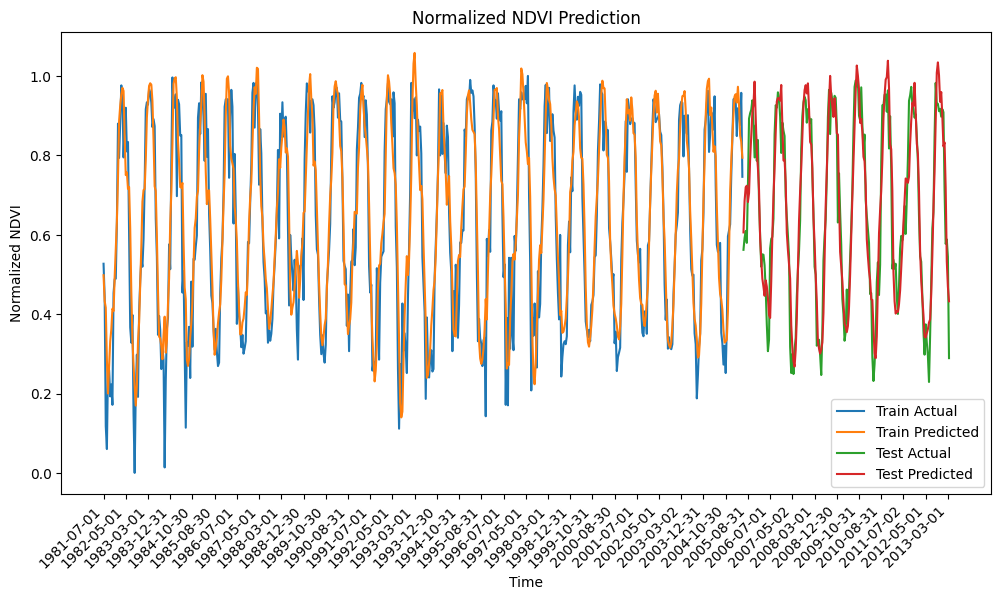

In [10]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse:.6f}')
print(f'Test RMSE: {test_rmse:.6f}')

# Extract predicted and actual values for each variable
NDVI_real_train = y_train[:, 0]
NDVI_pred_train = train_predict[:, 0]
NDVI_real_test = y_test[:, 0]
NDVI_pred_test = test_predict[:, 0]

# Plot NDVI
plt.figure(figsize=(12, 6))
plt.plot(train_time_index[look_back+1:], NDVI_real_train, label='Train Actual')
plt.plot(train_time_index[look_back+1:], NDVI_pred_train, label='Train Predicted')
plt.plot(test_time_index[look_back+1:], NDVI_real_test, label='Test Actual')
plt.plot(test_time_index[look_back+1:], NDVI_pred_test, label='Test Predicted')
plt.title('Normalized NDVI Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized NDVI')
tick_frequency = 20
plt.xticks(range(0, len(time_index), tick_frequency), time_index[::tick_frequency], rotation=90)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


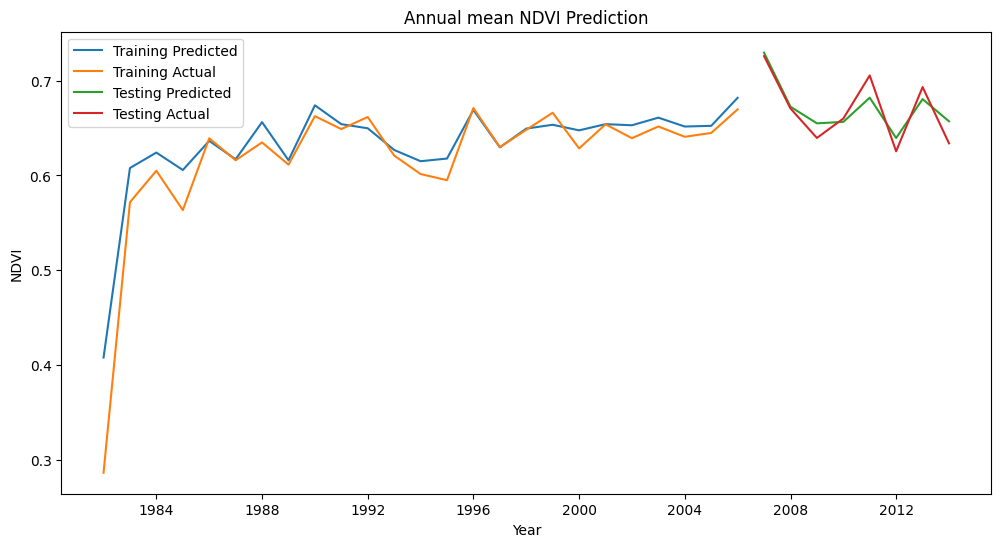

In [21]:
# Resample to annual frequency
train_time_index = pd.to_datetime(train_time_index)
test_time_index = pd.to_datetime(test_time_index)

train_predict_annual = pd.Series(train_predict[:, 0], index=train_time_index[look_back+1:]).resample('A').mean()
y_train_annual = pd.Series(y_train[:, 0], index=train_time_index[look_back+1:]).resample('A').mean()
test_predict_annual = pd.Series(test_predict[:, 0], index=test_time_index[look_back+1:]).resample('A').mean()
y_test_annual = pd.Series(y_test[:, 0], index=test_time_index[look_back+1:]).resample('A').mean()

# Plot the predicted and actual values for each year
plt.figure(figsize=(12, 6))
plt.plot(train_predict_annual.index, train_predict_annual, label='Training Predicted')
plt.plot(y_train_annual.index, y_train_annual, label='Training Actual')
plt.plot(test_predict_annual.index, test_predict_annual, label='Testing Predicted')
plt.plot(y_test_annual.index, y_test_annual, label='Testing Actual')
plt.title('Annual mean NDVI Prediction')
plt.xlabel('Year')
plt.ylabel('NDVI')
plt.legend()
plt.show()


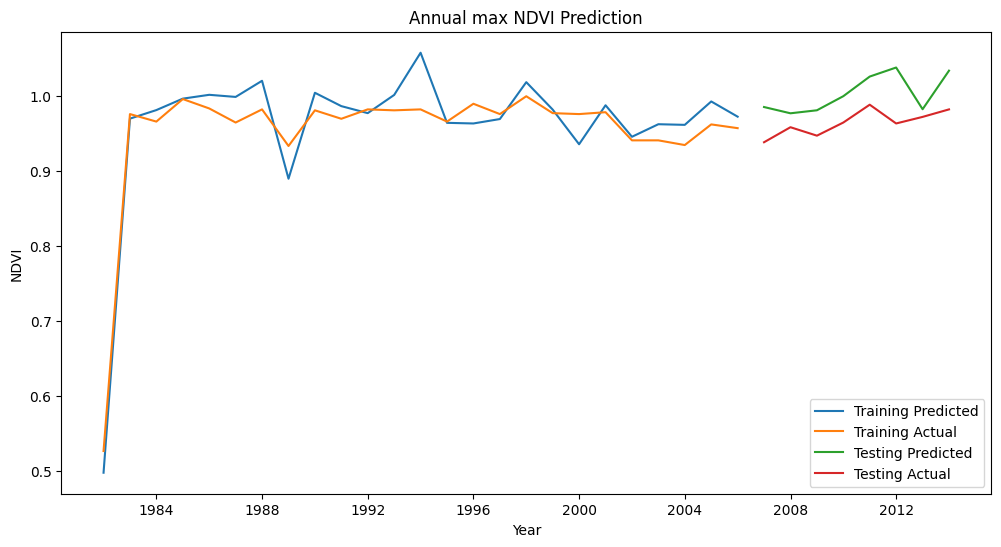

In [22]:
# Resample to annual frequency
train_time_index = pd.to_datetime(train_time_index)
test_time_index = pd.to_datetime(test_time_index)

train_predict_annual = pd.Series(train_predict[:, 0], index=train_time_index[look_back+1:]).resample('A').max()
y_train_annual = pd.Series(y_train[:, 0], index=train_time_index[look_back+1:]).resample('A').max()
test_predict_annual = pd.Series(test_predict[:, 0], index=test_time_index[look_back+1:]).resample('A').max()
y_test_annual = pd.Series(y_test[:, 0], index=test_time_index[look_back+1:]).resample('A').max()

# Plot the predicted and actual values for each year
plt.figure(figsize=(12, 6))
plt.plot(train_predict_annual.index, train_predict_annual, label='Training Predicted')
plt.plot(y_train_annual.index, y_train_annual, label='Training Actual')
plt.plot(test_predict_annual.index, test_predict_annual, label='Testing Predicted')
plt.plot(y_test_annual.index, y_test_annual, label='Testing Actual')
plt.title('Annual max NDVI Prediction')
plt.xlabel('Year')
plt.ylabel('NDVI')
plt.legend()
plt.show()
